In [9]:
import sys
sys.path.append('../')

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})

%matplotlib inline

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from bert.dataset import encoding_table

In [12]:
swissprot = pd.read_parquet('/projects/bpms/pstjohn/swissprot/parsed_swissprot.parquet') # To test
swissprot['sequence'] = '^' + swissprot.sequence + '$'  # Append the start and end characters
swissprot_sample = swissprot[swissprot.length < 1024].sample(100, random_state=1)

In [13]:
swissprot_sample = swissprot_sample.append(swissprot[swissprot.Pfam == 'PF17297'].iloc[0])

In [14]:
pfam_db = swissprot_sample.dropna(subset=['Pfam']).drop_duplicates(subset=['Pfam'], keep='first')
query = swissprot[(swissprot.Pfam == 'PF17297') & ~swissprot.index.isin(pfam_db.index)].head(1)

In [15]:
pfam_db.shape

(92, 9)

In [16]:
pfam_db[pfam_db.Pfam == 'PF17297']

,accession,EMBL,RefSeq,KEGG,InterPro,Pfam,NCBI Taxonomy,length,sequence
145680,A0JSP6,CP000454,WP_011690534.1,art:Arth_0667,IPR008210,PF17297,290399,611,^MGDLARLPLLEKAPTTHAGLLAWVEEVAELTQPDRIHWVDGTEEE...


In [17]:
query

,accession,EMBL,RefSeq,KEGG,InterPro,Pfam,NCBI Taxonomy,length,sequence
145681,Q05893,L01787,None,None,IPR008210,PF17297,6253,643,^MRCRSLSHFKDDDFAVVSEVVTHKQNHIPVIKGDFVSLPKHVQRF...


In [18]:
(pfam_db.sequence.apply(len) == pfam_db.length + 2).all()

True

In [19]:
from bert.model import create_albert_model

model = create_albert_model(model_dimension=512,
                            transformer_dimension=512 * 4,
                            num_attention_heads=512 // 64,
                            num_transformer_layers=6,
                            vocab_size=24,
                            dropout_rate=0.,
                            max_relative_position=64,
                            final_layernorm=True)


model.load_weights('/projects/bpms/pstjohn/trained_models/dist_sl128_nowd_checkpoints/saved_weights').expect_partial()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 512)         12288     
_________________________________________________________________
transformer (Transformer)    (None, None, 512)         2897984   
_________________________________________________________________
transformer_1 (Transformer)  (None, None, 512)         2897984   
_________________________________________________________________
transformer_2 (Transformer)  (None, None, 512)         2897984   
_________________________________________________________________
transformer_3 (Transformer)  (None, None, 512)         2897984   
_________________________________________________________________
transformer_4 (Transformer)  (None, None, 512)         289798

In [20]:
model.input

<tf.Tensor 'input_1:0' shape=(None, None) dtype=int32>

In [21]:
flat_embeddings = tf.boolean_mask(model.layers[-1].input, model.input != 0)
embedding_model = tf.keras.models.Model(model.input, flat_embeddings)

In [22]:
seq_dataset = tf.data.Dataset.from_tensor_slices(pfam_db.sequence)\
    .map(tf.strings.bytes_split)\
    .padded_batch(5, [-1,])\
    .map(encoding_table.lookup)

In [23]:
result = embedding_model.predict(seq_dataset, verbose=1)

19/19 [==============================] - 4s 221ms/step


In [24]:
result.shape

(32281, 512)

In [25]:
index_df = pd.DataFrame(
    np.vstack([np.repeat(pfam_db.Pfam.values, pfam_db.length + 2),
               np.concatenate([np.arange(length + 2) for length in pfam_db.length])]).T,
    columns=['Pfam', 'AA'])

In [26]:
index_df.shape

(32281, 2)

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA()
results_pca = pca.fit_transform(result)

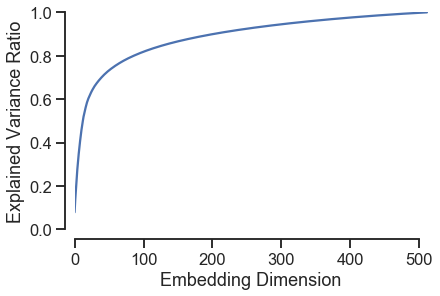

In [37]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Embedding Dimension')
plt.ylabel('Explained Variance Ratio')
plt.tight_layout()
plt.ylim([0, 1])
plt.xlim([0, 512])
sns.despine(trim=True, offset=10)

In [30]:
# index_df.join(pd.DataFrame(results_pca[:, :10]))

In [61]:
query_dataset = tf.data.Dataset.from_tensor_slices(query.sequence)\
    .map(tf.strings.bytes_split)\
    .padded_batch(10, [-1,])\
    .map(encoding_table.lookup)

query_results = embedding_model.predict(query_dataset)
query_results_pca = pca.transform(query_results)

query_index_df = pd.DataFrame(
    np.vstack([np.repeat(query.accession.values, query.length + 2),
               np.concatenate([np.arange(length + 2) for length in query.length])]).T,
    columns=['accession', 'AA'])

In [62]:
result.shape

(32281, 512)

In [63]:
query_results.shape

(645, 512)

In [75]:
d = 512
x_database = np.ascontiguousarray(results_pca[:, :d])
x_query = np.ascontiguousarray(query_results_pca[:, :d])

x_database = x_database / np.linalg.norm(x_database, axis=1)[:, np.newaxis]
x_query = x_query / np.linalg.norm(x_query, axis=1)[:, np.newaxis]

In [76]:
distances = x_query.dot(x_database.T)

In [77]:
distances.shape

(645, 32281)

In [195]:
max_by_pfam = pd.DataFrame(distances.T).groupby(index_df.Pfam).max().drop([0, 644], 1)

In [196]:
max_by_pfam.quantile()

1      0.944903
2      0.770834
3      0.645909
4      0.817570
5      0.857266
         ...   
639    0.726890
640    0.763207
641    0.806757
642    0.768330
643    0.763409
Name: 0.5, Length: 643, dtype: float64

In [198]:
df = pd.concat([max_by_pfam.drop('PF17297').median(0), max_by_pfam.drop('PF17297').quantile(.95), max_by_pfam.loc['PF17297']], 1)
df.columns = ['median', '95', 'PF17297']
df_sort = df.sort_values('PF17297', ascending=False).reset_index()

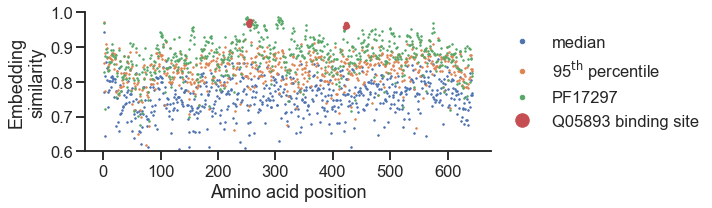

In [227]:
#_ = plt.plot(max_by_pfam.T, color='k', alpha=.05)

plt.figure(figsize=(10,3))

_ = plt.plot(max_by_pfam.drop('PF17297').median(0), '.', ms=3, label='median')
_ = plt.plot(max_by_pfam.drop('PF17297').quantile(.95), '.', ms=3, label='95${}^{\mathrm{th}}$ percentile')

_ = plt.plot(max_by_pfam.loc['PF17297'], '.', ms=3, label='PF17297')
_ = plt.plot(np.arange(253, 256), max_by_pfam.loc['PF17297', 253:255], '.', color='r', label='Q05893 binding site')
_ = plt.plot(np.arange(422, 425), max_by_pfam.loc['PF17297', 422:424], '.', color='r')

plt.ylim([.6, 1.0])
plt.legend(loc='center left', bbox_to_anchor=(1., .5), markerscale=3)
sns.despine()

plt.ylabel('Embedding\nsimilarity')
plt.xlabel('Amino acid position')

plt.tight_layout()
plt.savefig('Q05893_similarity.svg')

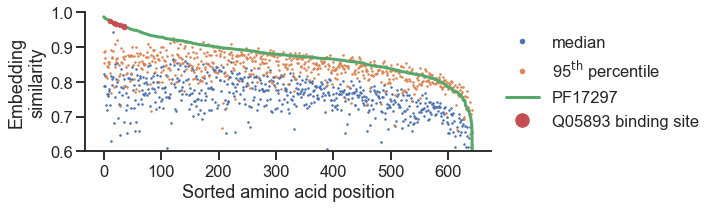

In [226]:
plt.figure(figsize=(10,3))

plt.plot(df_sort['median'], '.', ms=3, label='median')
plt.plot(df_sort['95'], '.', ms=3, label='95${}^{\mathrm{th}}$ percentile')
plt.plot(df_sort.PF17297, lw=3, label='PF17297')
plt.plot(df_sort[df_sort['index'].isin([253, 254, 255, 422, 423, 424])].PF17297, '.', color='r', label='Q05893 binding site')

plt.ylim([.6, 1.0])
plt.legend(loc='center left', bbox_to_anchor=(1., .5), markerscale=3)
sns.despine()

plt.ylabel('Embedding\nsimilarity')
plt.xlabel('Sorted amino acid position')

plt.tight_layout()
plt.savefig('Q05893_sorted.svg')

# save results

In [ ]:
# index_df.join(
#     pd.DataFrame(results_pca, columns=np.arange(512).astype(str))
# ).to_parquet('/scratch/pstjohn/nn_embeddings/pfam.parquet')

In [ ]:
# query_index_df.join(
#     pd.DataFrame(query_results_pca, columns=np.arange(512).astype(str))
# ).to_parquet('/scratch/pstjohn/nn_embeddings/query.parquet')